# Strain Rate Methodology
Started Jan 10 2024 by George Lu

Last modified Jan 16 2024 by George Lu

This Jupyter notebook will be the definitive methodology notebook for englacial strain rate calculations using ApRES data from the Greenland Lakes 2022-2023 field campaign. It will proceed as follows, for each station and season (we start our analysis with winter season data as it is cleanest):
1. Derive clean profile data for each individual burst. We will use our least conservative gain settings because we can then apply our half-chirp filter to neglect clipping. Since if the signal is clipped, changing the gain does not prevent it from happening, but it does hide its immediately noticeable effects.
    1. If clipping effects are observed, only use the latter half of the chirp.
    2. Consider normalizing average amplitude across bursts to remove surface/electronic effects.
2. Once we have our profile series, determine an average strain rate by summing up the total displacement over the season. 
3. Then, determine an optimal window length for leapfrog method. Essentially, calculate strain rate between bursts shifted further apart in the season until they converge to the average strain rate. This method should work better than our previously used summation method as it preserves temporal resolution and also has lower error. 
4. Alter this window surrounding lake drainages if necessary.

# Set up code

In [1]:
# Load libraries
import sys
import sys
sys.path.append("../../xapres_package/")
import ApRESDefs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 

import xarray as xr
import importlib
import pandas as pd
import math
from datetime import datetime, timedelta, date
from scipy.stats import linregress


importlib.reload(ApRESDefs)
xa = ApRESDefs.xapres(loglevel='debug')

DEBUG    14:49:30 	 ApRESDefs.py @function _setup_logging line 615 - Stream logging level set to DEBUG
DEBUG    14:49:30 	 ApRESDefs.py @function _setup_logging line 616 - Add console handler to logger
DEBUG    14:49:30 	 ApRESDefs.py @function _setup_logging line 629 - File logging level set to DEBUG


In [2]:
# Load data
def reload(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        chunks={}) 
    return ds

ds_101 = reload("A101")
ds_103 = reload("A103_fixed")
ds_104 = reload("A104")

ds_101 = ds_101.isel(time=range(20,len(ds_101.time)))
ds_103 = ds_103.isel(time=range(60,len(ds_103.time)))
ds_104 = ds_104.isel(time=range(50,len(ds_104.time)))


def reload_winter(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}_winter22_23'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        consolidated=True, 
        chunks={}) 
    return ds

ds_101_w = reload_winter("A101")
ds_103_w = reload_winter("A103")
ds_104_w = reload_winter("A104")

def reload_summer(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}_summer_23'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        consolidated=True, 
        chunks={}) 
    return ds

ds_101_s = reload_summer("A101")
ds_103_s = reload_summer("A103")
ds_104_s = reload_summer("A104")

In [3]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:38383")
client

<Client: 'tcp://127.0.0.1:38383' processes=4 threads=16, memory=125.81 GiB>

# Plot all measurements

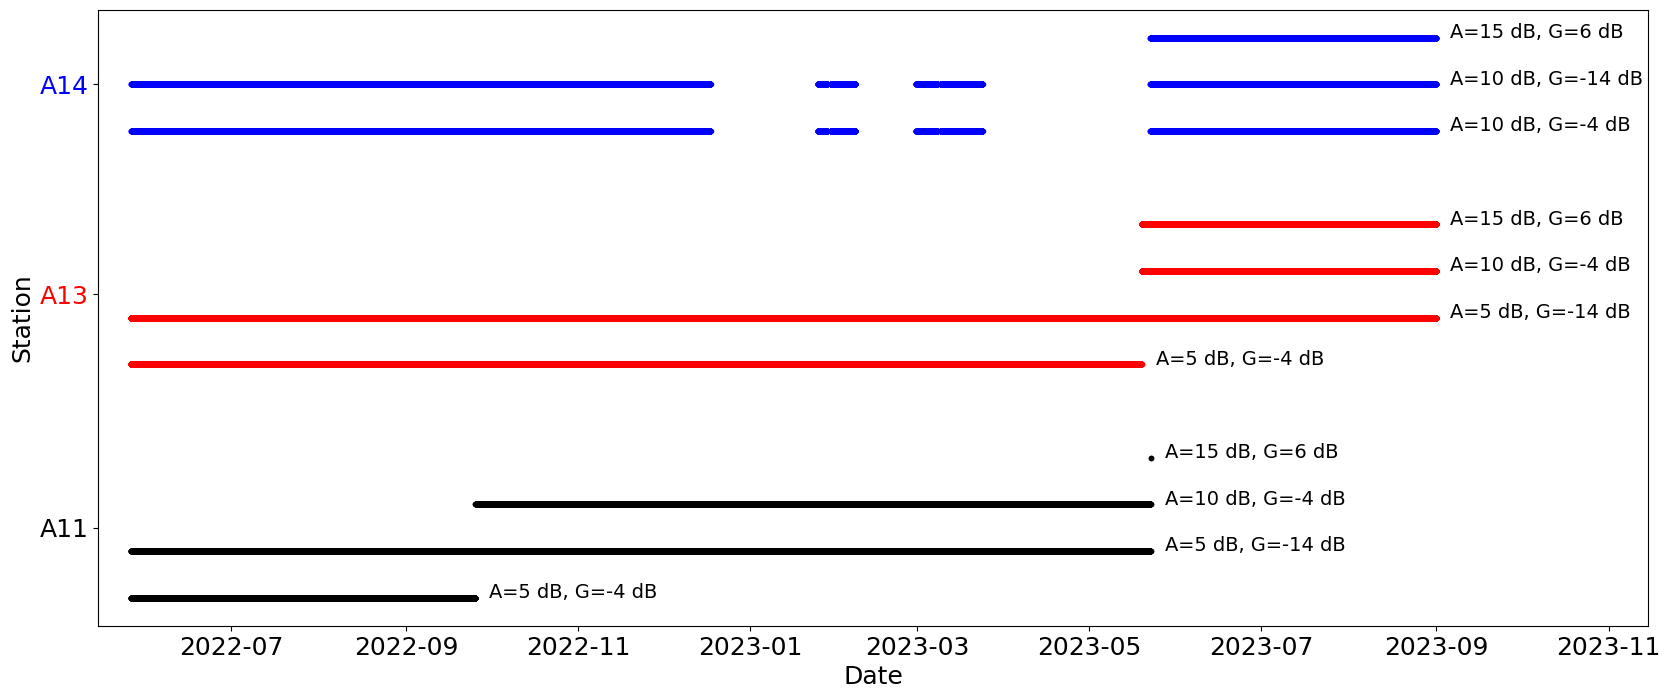

In [4]:
fig, ax = plt.subplots(figsize=(20,8))
anchors = [0,1,2]
a101 = [ds_101,ds_101_w, ds_101_s]
a103 = [ds_103,ds_103_w, ds_103_s]
a104 = [ds_104,ds_104_w, ds_104_s]
site_array = [a101,a103,a104]
site_names = ['A11','A13','A14']
station_colors = ['black','red','blue']
true_anchors = []

for i in anchors:
    station_array = site_array[i]
    setting_count = 0
    setting_pairs = []
    labels = []
    for season in station_array:
        for j in range(len(season.attenuator_setting_pair)):
            pair = (season.attenuator.values[j],season.AFGain.values[j])
            if pair not in setting_pairs:
                setting_pairs.append(pair)
                anchor_point = i + 0.2*setting_count
                setting_count += 1   
                plt.plot(season.time.values,anchor_point*np.ones(season.time.values.shape),linestyle='None',marker='.',color=station_colors[i])
                text = ax.text(season.time.values[-1]+np.timedelta64(5,'D'),anchor_point,f'A={int(pair[0])} dB, G={pair[1]} dB',fontsize=14)
                labels.append(text)
            else:
                anchor_point = i + 0.2*setting_pairs.index(pair)
                plt.plot(season.time.values,anchor_point*np.ones(season.time.values.shape),linestyle='None',marker='.',color=station_colors[i])
                labels[setting_pairs.index(pair)].set_position((season.time.values[-1]+np.timedelta64(5,'D'),anchor_point))

    true_anchors.append(i + 0.1*(setting_count-1))
ax.set_yticks(true_anchors)
ax.set_yticklabels(site_names,fontsize=14)
for ytick, color in zip(ax.get_yticklabels(), station_colors):
    ytick.set_color(color)
plt.xlim([np.datetime64('2022-05-15'), np.datetime64('2023-11-15')])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Station',fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)


# Define helper functions
This is to streamline the code

In [4]:
# define function
def custom_stacked_profile_series(chirps,pad=2,F0=2e8,F1=4e8):
    StartFreq = 2e8
    StopFreq = 4e8
    B = StopFreq - StartFreq
    CentreFreq = B/2
    K = 2e8 
    dt = 1/40000
    c0 = 3e8 # speed of light in vaccuum
    ER_ICE = 3.18
    T0 = (F0-StartFreq)/K
    T1 = (F1-StartFreq)/K

    chirps = chirps.isel(chirp_time=range(math.ceil(T0/dt),math.floor(T1/dt)+1)).mean(dim='chirp_num')
    window = np.blackman(len(chirps.chirp_time))
    win_chirps = chirps*window
    Nt = len(chirps.chirp_time)
    Nfft = math.floor(Nt*pad)
    bin2m = c0/(2.*(T1-T0)*pad*math.sqrt(ER_ICE)*K)
    profile_range = np.asarray([i for i in range(Nfft)]) * bin2m      
    profile_range = profile_range[0:math.floor(Nfft/2)-1]
    padchirp = np.zeros((len(chirps.time),Nfft))
    padchirp[:,0:math.floor(Nt/2)] = win_chirps.data[:,math.floor(Nt/2):-1]
    padchirp[:,-math.floor(Nt/2):] = win_chirps.data[:,0:math.floor(Nt/2)]
    p = np.fft.fft(padchirp,axis=1)/Nfft * math.sqrt(2*pad)
    profile = p[:,0:math.floor(Nfft/2)-1]
    m = np.asarray([i for i in range(profile.shape[1])])/pad
    phiref = 2*math.pi*CentreFreq*m/B - m * m * 2*math.pi * K/2/B**2
    profile_ref = profile * np.exp(phiref[np.newaxis,:]*(-1j))
    profile_range = np.asarray([i for i in range(Nfft)]) * bin2m      
    profile_range = profile_range[0:math.floor(Nfft/2)-1]
    n = np.argmin(profile_range<=1400)
    Range = profile_range[:n]
    Profile = profile_ref[:,:n]
    da = xr.DataArray(Profile,
                  dims=['time','profile_range'],
                  coords={'profile_range': Range,
                         'time': chirps.time.data})
    return da

def strain_metrics(ds, win_cor, step, lag):
    # This function, given a window, and step, gives a total percentage of data that has high coherence
    b1 = ds.isel(time=range(0,len(ds)-lag))
    b2 = ds.isel(time=range(lag,len(ds)))
    dz, co, phi = xa.generate_range_diff(b1,b2,win_cor,step,None,0,0.95)
    dz=dz.assign(coherence=(['time','profile_range'],co))
    dz_new = dz.where(abs(dz.coherence) > 0.95).drop_duplicates('time')

    vv = dz_new.range_diff / dz_new.time_diff * 31536000
    vv_err = dz_new.err / dz_new.time_diff * 31536000
    fit=vv.where(vv.profile_range <=600).polyfit('profile_range',1,full=True)
    r2 = 1-fit.polyfit_residuals/((vv-vv.mean())**2).sum(dim='profile_range')
    return np.count_nonzero(abs(co)>0.95)/np.count_nonzero(co), np.mean(abs(co)), np.mean(r2).values

def optimal_window_and_leapfrog(ds):
    max_score = 0
    windows = np.arange(20,90,10)
    lags = np.round(np.logspace(0,3,7)).astype('int')
    pct_mat = np.zeros((len(windows),len(lags)))
    r2_mat = np.zeros((len(windows),len(lags)))
    for i in range(len(windows)):
        step = windows[i] # earlier experiments show step doesn't change results by much
        #for step in [10,20,40,80]:
        #    if step <= window:
        for j in range(len(lags)):
            pct,mean,r2 = strain_metrics(ds, windows[i], step,lags[j])
            print(f"Window {windows[i]}, lag {lags[j]} -> pct {pct:.2}, r2 {r2:.2}")
            pct_mat[i,j] = pct
            r2_mat[i,j]=r2
            # mean coherence not relevant I think
            temp_score = pct+r2
            if temp_score > max_score:
                max_score = temp_score
                to_return = windows[i],lags[j]
            
    fig, axs = plt.subplots(ncols=2,figsize=(15,5))
    plt0 = axs[0].pcolormesh(100*pct_mat)
    plt.colorbar(plt0,ax=axs[0],label='percentage of data with high coherence (>0.95)')
    axs[0].set_xticks(np.arange(pct_mat.shape[1]) + 0.5, minor=False)
    axs[0].set_yticks(np.arange(pct_mat.shape[0]) + 0.5, minor=False)
    axs[0].set_xticklabels(lags)
    axs[0].set_yticklabels(windows)
    axs[0].set_ylabel('Correlation window size [points included]')
    axs[0].set_xlabel('Lag between bursts [num. bursts seperated]')
    axs[0].set_title('High coherence percentage')


    plt1 = axs[1].pcolormesh(r2_mat)
    plt.colorbar(plt1,ax=axs[1],label='Average r^2 of linear strain fits')
    axs[1].set_xticks(np.arange(r2_mat.shape[1]) + 0.5, minor=False)
    axs[1].set_yticks(np.arange(r2_mat.shape[0]) + 0.5, minor=False)
    axs[1].set_xticklabels(lags)
    axs[1].set_yticklabels(windows)
    axs[1].set_ylabel('Correlation window size [points included]')
    axs[1].set_xlabel('Lag between bursts [num. bursts seperated]')
    axs[1].set_title('Mean strain rate fit r-squared')

    return to_return

def generate_strain_fit(ds,window,lag):
    b1= ds.isel(time=range(0,len(ds)-lag))
    b2 = ds.isel(time=range(lag,len(ds)))
    ds_full, co_full, phi_full = xa.generate_range_diff(b1,b2,window,window,None,0,0.95)
    ds_full=ds_full.assign(coherence=(['time','profile_range'],co_full))
    ds_new = ds_full.where(abs(ds_full.coherence) > 0.95).drop_duplicates('time')

    vv = ds_new.range_diff / ds_new.time_diff * 31536000
    vv_err = ds_new.err / ds_new.time_diff * 31536000
    fit=vv.where(vv.profile_range <=600).polyfit('profile_range',1,full=True)
    r2 = 1-fit.polyfit_residuals/((vv-vv.mean())**2).sum(dim='profile_range')
    fig, axs = plt.subplots(nrows=2,figsize=(10,6),sharex=True)
    axs[0].plot(fit.time.values,fit.polyfit_coefficients.sel(degree=1).values)
    #axs[0].set_ylim([-1e-2,1e-2])
    axs[0].set_ylabel('Strain rate [y$^{-1}$]')
    axs[0].set_title('Strain fitting results')
    axs[1].plot(fit.time.values,r2.values)
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('r$^2$')
    #return ds_new,fit

# Station A11

## Winter 2022-2023
We will use settings A = 10 dB and G = -4 dB

In [6]:
to_plot = ds_101_w.profile_stacked.isel(attenuator_setting_pair=0).compute()
to_plot

<xarray.DataArray 'profile_stacked' (time: 22956, profile_range: 6658)>
array([[ 1.06155799e-02+0.00000000e+00j,  4.40950831e-06+9.35005244e-03j,
        -6.30365131e-03+4.71999350e-06j, ...,
         2.28379525e-06-5.04751408e-07j, -2.20321862e-06-2.18208259e-06j,
         6.07039677e-06-2.58502522e-06j],
       [ 1.06032189e-02+0.00000000e+00j,  9.55612285e-06+9.34236374e-03j,
        -6.30428694e-03+7.82434236e-06j, ...,
         7.16780930e-06-5.85136580e-06j,  5.39498104e-06+8.33708840e-06j,
        -9.15188298e-06+4.44964330e-06j],
       [ 1.06072221e-02+0.00000000e+00j,  2.18712181e-05+9.35629798e-03j,
        -6.34048535e-03+2.51163593e-05j, ...,
         5.49882332e-07-5.09102075e-06j,  4.93319378e-06+8.92188559e-07j,
        -1.83328135e-06+3.95056138e-06j],
       ...,
       [ 1.05856116e-02+0.00000000e+00j,  7.71162382e-06+9.32832327e-03j,
        -6.30549143e-03+1.54140183e-05j, ...,
        -1.26195549e-06-3.37637842e-06j,  3.90827760e-06+2.24720067e-07j,
        -2.19971420e-06+2.52605882e-06j],
       [ 1.05802997e-02+0.00000000e+00j,  7.97135856e-06+9.32365618e-03j,
        -6.30238432e-03+1.58166440e-05j, ...,
        -3.54655523e-07-1.34851027e-06j,  3.56401689e-06+3.29373087e-07j,
        -2.17010393e-06+4.27161526e-06j],
       [ 1.05839879e-02+0.00000000e+00j,  7.76490620e-06+9.32684984e-03j,
        -6.30443640e-03+1.55134541e-05j, ...,
         2.01931501e-06-2.35314612e-06j,  2.52795123e-06+3.01144527e-06j,
        -3.79231508e-06+1.55249383e-06j]])
Coordinates:
    AFGain         int64 -4
    attenuator     float64 10.0
    burst_number   (time) int64 0 0 1 2 3 4 5 6 7 ... 42 43 44 45 46 47 48 49 50
    filename       (time) <U89 'ldeo-glaciology/GL_apres_2022/A101/winter22_2...
  * profile_range  (profile_range) float64 0.0 0.2103 0.4206 ... 1.4e+03 1.4e+03
  * time           (time) datetime64[ns] 2022-09-25T15:29:31 ... 2023-05-22T1...

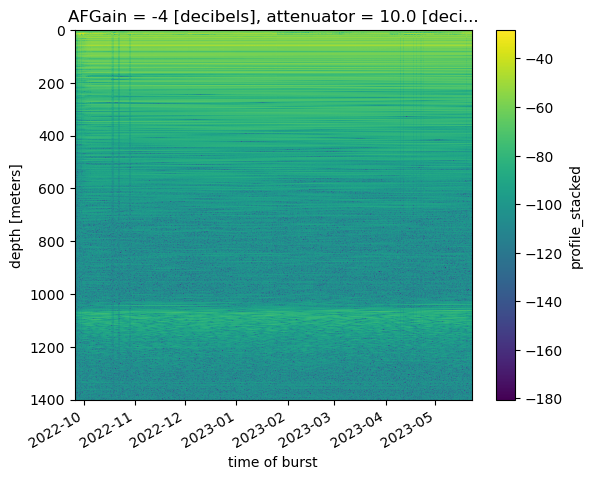

In [7]:
fig, ax = plt.subplots()

xa.dB(to_plot).plot(ax=ax,x='time')
ax.invert_yaxis()

Doesn't look like there's clipping so we proceed.

### Strain Rates

Window 20, lag 1 -> pct 0.56, r2 0.68
Window 20, lag 3 -> pct 0.56, r2 0.69
Window 20, lag 10 -> pct 0.55, r2 0.71
Window 20, lag 32 -> pct 0.54, r2 0.81
Window 20, lag 100 -> pct 0.49, r2 0.93
Window 20, lag 316 -> pct 0.44, r2 0.96
Window 20, lag 1000 -> pct 0.34, r2 0.95
Window 30, lag 1 -> pct 0.55, r2 0.64
Window 30, lag 3 -> pct 0.55, r2 0.65
Window 30, lag 10 -> pct 0.55, r2 0.68
Window 30, lag 32 -> pct 0.53, r2 0.83
Window 30, lag 100 -> pct 0.48, r2 0.95
Window 30, lag 316 -> pct 0.43, r2 0.96
Window 30, lag 1000 -> pct 0.33, r2 0.96
Window 40, lag 1 -> pct 0.55, r2 0.62
Window 40, lag 3 -> pct 0.55, r2 0.64
Window 40, lag 10 -> pct 0.54, r2 0.69
Window 40, lag 32 -> pct 0.53, r2 0.85
Window 40, lag 100 -> pct 0.48, r2 0.96
Window 40, lag 316 -> pct 0.43, r2 0.96
Window 40, lag 1000 -> pct 0.33, r2 0.96
Window 50, lag 1 -> pct 0.55, r2 0.62
Window 50, lag 3 -> pct 0.55, r2 0.63
Window 50, lag 10 -> pct 0.54, r2 0.69
Window 50, lag 32 -> pct 0.53, r2 0.87
Window 50, lag 100 ->

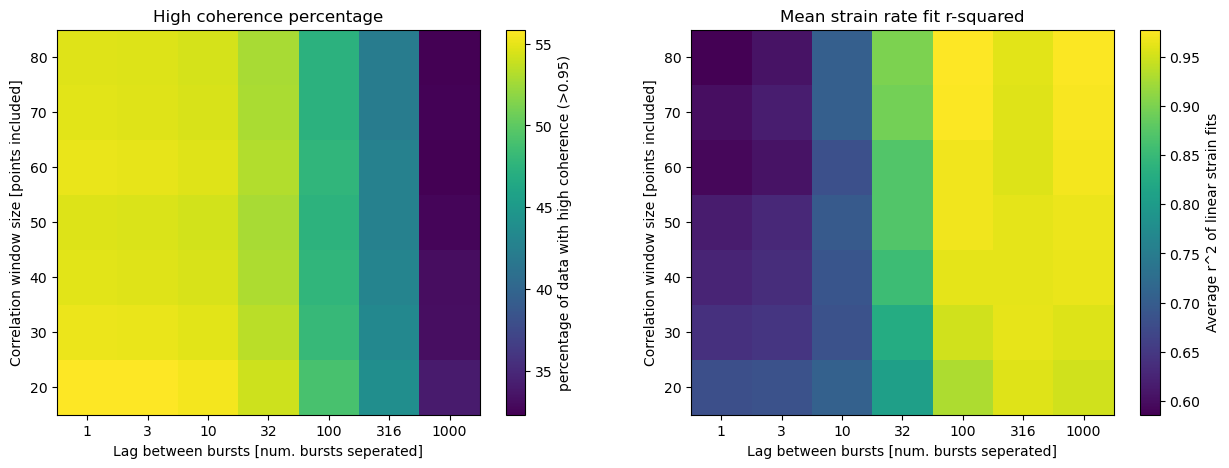

In [8]:
best_window,best_lag = optimal_window_and_leapfrog(to_plot)
print(f'Best window: {best_window}, best lag: {best_lag}')

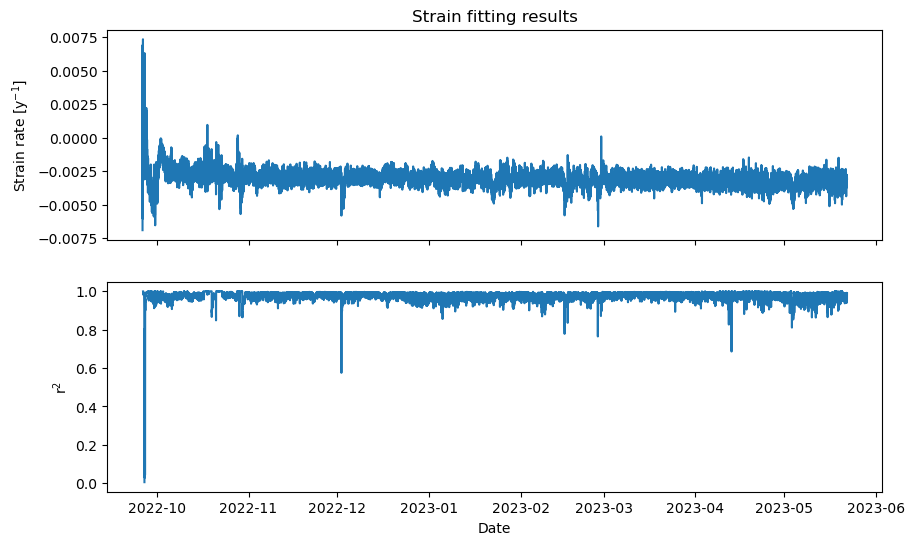

In [9]:
generate_strain_fit(to_plot,best_window,best_lag)

In [10]:
del to_plot

## Summer 2022
### Profiles
We will use settings A= 5dB and G = -4 dB.

In [11]:
to_plot = ds_101.profile_stacked.isel(attenuator_setting_pair=0).compute()
to_plot

<xarray.DataArray 'profile_stacked' (time: 11703, profile_range: 6658)>
array([[ 1.04618385e-02+0.00000000e+00j,  4.26501701e-05+9.23693327e-03j,
        -6.27796425e-03+4.34813737e-05j, ...,
         1.19840332e-05-8.55320893e-06j,  9.51972256e-06+1.49376352e-05j,
        -1.99264496e-05+7.62303980e-06j],
       [ 1.04713755e-02+0.00000000e+00j,  3.16996879e-05+9.23876915e-03j,
        -6.26616003e-03+3.56836393e-05j, ...,
         1.24221107e-05-4.38062301e-06j,  3.64861291e-06+1.68034519e-05j,
        -1.85948221e-05+3.34217248e-06j],
       [ 1.04737567e-02+0.00000000e+00j,  2.74290772e-05+9.23850750e-03j,
        -6.26121460e-03+3.21018924e-05j, ...,
         1.22516167e-05-1.86013973e-05j,  1.92774619e-05+1.39392061e-05j,
        -1.68664879e-05+1.85494071e-05j],
       ...,
       [ 1.06564243e-02+0.00000000e+00j,  1.51908274e-05+9.38728904e-03j,
        -6.33305665e-03+2.55492919e-05j, ...,
        -5.23737037e-06-1.52326609e-05j,  1.82422943e-05-4.59996309e-06j,
        -4.47682238e-08+2.01448523e-05j],
       [ 1.06552117e-02+0.00000000e+00j,  1.52172810e-05+9.38625681e-03j,
        -6.33250474e-03+2.55823169e-05j, ...,
        -3.53101608e-06-5.05086022e-06j,  5.85621273e-06-3.96907292e-06j,
         6.55683225e-07+5.17477337e-06j],
       [ 1.06560206e-02+0.00000000e+00j,  1.52961658e-05+9.38692359e-03j,
        -6.33288430e-03+2.57586554e-05j, ...,
         3.65597878e-06-7.35152059e-06j,  1.14461841e-06+2.17295685e-06j,
        -2.11383541e-07-3.47928806e-06j]])
Coordinates:
    AFGain         int64 -4
    attenuator     float64 5.0
    burst_number   (time) int64 6 7 8 9 10 11 12 13 ... 61 62 63 64 65 66 67 68
    filename       (time) <U83 'ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2...
  * profile_range  (profile_range) float64 0.0 0.2103 0.4206 ... 1.4e+03 1.4e+03
  * time           (time) datetime64[ns] 2022-05-26T17:06:29 ... 2022-09-25T1...

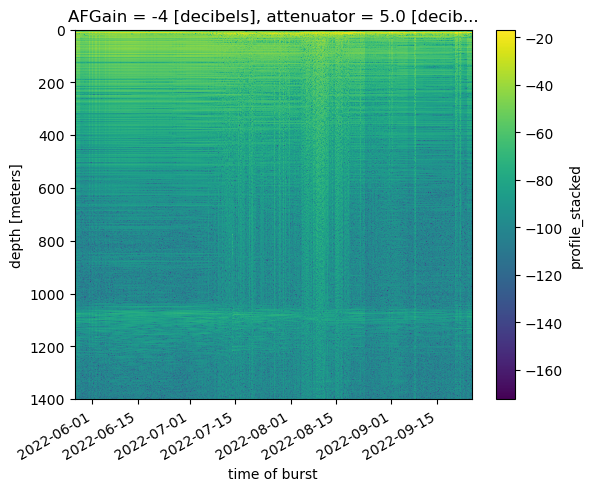

In [12]:
fig, ax = plt.subplots()

xa.dB(to_plot).plot(ax=ax,x='time')
ax.invert_yaxis()

We see from using the full chirp, there is clipping. Consequently, we apply our half chirp. 

In [13]:
da_101_stacked  = custom_stacked_profile_series(ds_101.chirp.isel(attenuator_setting_pair=0),2,3e8,4e8)


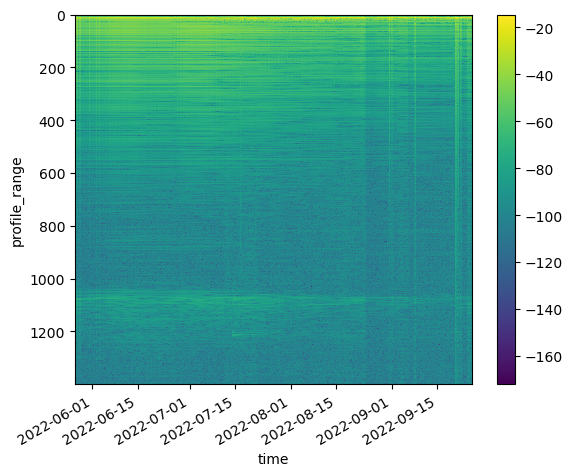

In [14]:
fig, ax = plt.subplots()

xa.dB(da_101_stacked).plot(ax=ax,x='time')
ax.invert_yaxis()

Looks much better.

### Strain rates


Window 20, lag 1 -> pct 0.47, r2 0.55
Window 20, lag 3 -> pct 0.46, r2 0.56
Window 20, lag 10 -> pct 0.43, r2 0.63
Window 20, lag 32 -> pct 0.37, r2 0.73
Window 20, lag 100 -> pct 0.32, r2 0.82
Window 20, lag 316 -> pct 0.18, r2 0.84
Window 20, lag 1000 -> pct 0.068, r2 0.89
Window 30, lag 1 -> pct 0.46, r2 0.49
Window 30, lag 3 -> pct 0.45, r2 0.53
Window 30, lag 10 -> pct 0.42, r2 0.63
Window 30, lag 32 -> pct 0.36, r2 0.75
Window 30, lag 100 -> pct 0.31, r2 0.83
Window 30, lag 316 -> pct 0.17, r2 0.87
Window 30, lag 1000 -> pct 0.057, r2 0.92
Window 40, lag 1 -> pct 0.45, r2 0.47
Window 40, lag 3 -> pct 0.44, r2 0.52
Window 40, lag 10 -> pct 0.41, r2 0.66
Window 40, lag 32 -> pct 0.35, r2 0.79
Window 40, lag 100 -> pct 0.3, r2 0.86
Window 40, lag 316 -> pct 0.16, r2 0.93
Window 40, lag 1000 -> pct 0.051, r2 0.95
Window 50, lag 1 -> pct 0.45, r2 0.49
Window 50, lag 3 -> pct 0.44, r2 0.56
Window 50, lag 10 -> pct 0.41, r2 0.69
Window 50, lag 32 -> pct 0.35, r2 0.81
Window 50, lag 100 

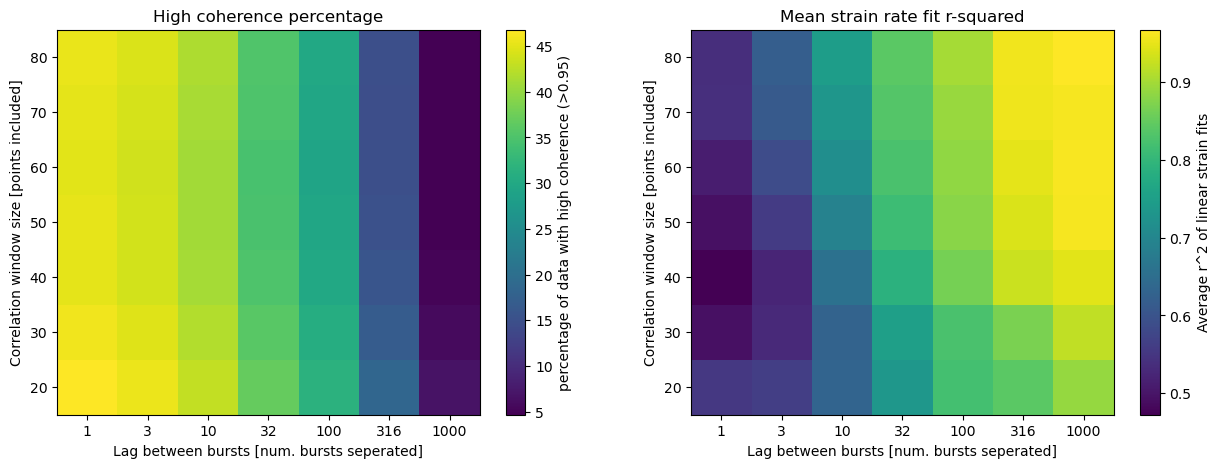

In [15]:
best_window,best_lag = optimal_window_and_leapfrog(da_101_stacked)
print(f'Best window: {best_window}, best lag: {best_lag}')

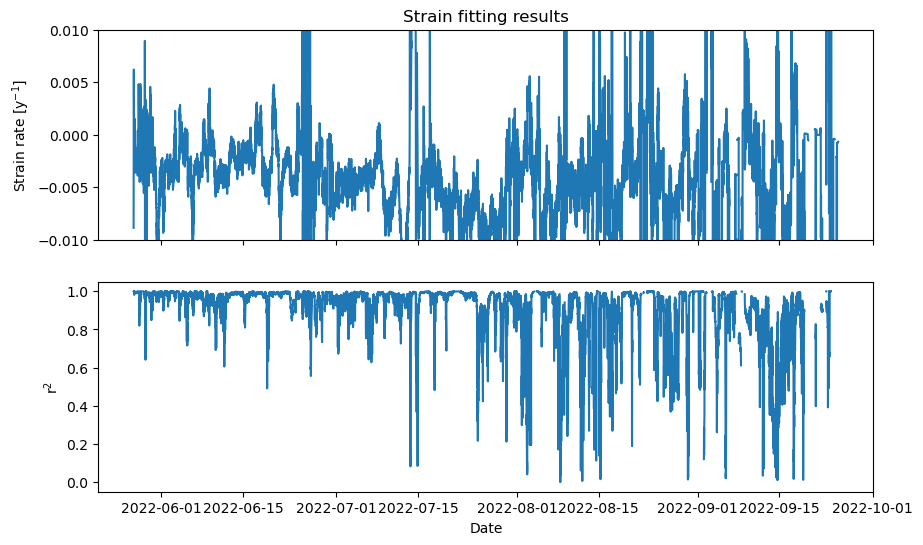

In [16]:
generate_strain_fit(da_101_stacked,best_window,best_lag)

In [17]:
del da_101_stacked

# Station A13

## Winter 2023
### Profiles
We will use settings A= 5dB and G = -4 dB.

In [18]:
to_plot = ds_103_w.profile_stacked.isel(attenuator_setting_pair=0).compute()
to_plot

<xarray.DataArray 'profile_stacked' (time: 22664, profile_range: 6658)>
array([[ 1.03592343e-02+0.00000000e+00j,  1.18348138e-05+9.13083918e-03j,
        -6.17072927e-03+7.44812331e-06j, ...,
        -1.11628441e-05-9.43537972e-05j,  7.49245075e-05-2.28843981e-05j,
         3.47570201e-05+3.67679076e-05j],
       [ 1.03484852e-02+0.00000000e+00j,  1.47345513e-05+9.12041716e-03j,
        -6.16025593e-03+1.65968080e-05j, ...,
         4.57949190e-05-4.22132157e-05j,  5.88205709e-05+2.43345476e-05j,
        -6.33728945e-06+5.48892869e-05j],
       [ 1.03513646e-02+0.00000000e+00j,  3.35703354e-05+9.11926192e-03j,
        -6.14680367e-03+4.90340506e-05j, ...,
        -5.82817517e-05+3.77641508e-05j, -7.39305131e-05-4.06034997e-05j,
         2.30337692e-05-1.02828498e-04j],
       ...,
       [ 1.03002240e-02+0.00000000e+00j,  1.57468426e-05+9.06989083e-03j,
        -6.11415662e-03+2.91432694e-05j, ...,
         2.94532985e-06-8.73865137e-06j,  8.35334035e-06+4.07496622e-06j,
        -3.26159927e-06+7.44086335e-06j],
       [ 1.02996497e-02+0.00000000e+00j,  1.50409352e-05+9.06921168e-03j,
        -6.11309004e-03+2.82384622e-05j, ...,
         1.86338709e-06-9.43442431e-06j,  1.20612655e-05-2.37426891e-07j,
        -3.61954890e-07+1.15440809e-05j],
       [ 1.03060849e-02+0.00000000e+00j,  1.60553570e-05+9.07548009e-03j,
        -6.11903290e-03+2.92516541e-05j, ...,
         6.46431707e-06-6.37062770e-06j,  1.91459244e-06+7.40315937e-06j,
        -5.65634618e-06-3.30352450e-06j]])
Coordinates:
    AFGain         int64 -4
    attenuator     float64 5.0
    burst_number   (time) int64 0 0 1 2 3 4 5 6 7 ... 14 15 16 17 18 19 20 21 22
    filename       (time) <U89 'ldeo-glaciology/GL_apres_2022/A103/winter22_2...
  * profile_range  (profile_range) float64 0.0 0.2103 0.4206 ... 1.4e+03 1.4e+03
  * time           (time) datetime64[ns] 2022-09-25T12:10:17 ... 2023-05-19T1...

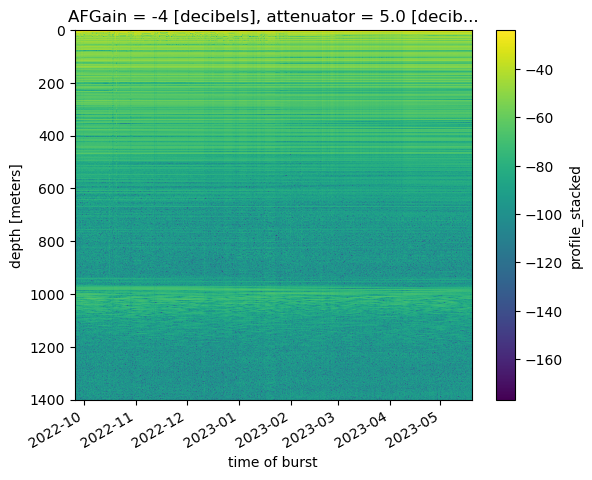

In [19]:
fig, ax = plt.subplots()

xa.dB(to_plot).plot(ax=ax,x='time')
ax.invert_yaxis()

Looks good on its own

### Strain Rates

Window 20, lag 1 -> pct 0.52, r2 0.67
Window 20, lag 3 -> pct 0.52, r2 0.67
Window 20, lag 10 -> pct 0.52, r2 0.69
Window 20, lag 32 -> pct 0.51, r2 0.73
Window 20, lag 100 -> pct 0.47, r2 0.79
Window 20, lag 316 -> pct 0.44, r2 0.87
Window 20, lag 1000 -> pct 0.42, r2 0.95
Window 30, lag 1 -> pct 0.52, r2 0.63
Window 30, lag 3 -> pct 0.52, r2 0.65
Window 30, lag 10 -> pct 0.51, r2 0.67
Window 30, lag 32 -> pct 0.5, r2 0.73
Window 30, lag 100 -> pct 0.46, r2 0.8
Window 30, lag 316 -> pct 0.44, r2 0.9
Window 30, lag 1000 -> pct 0.42, r2 0.97
Window 40, lag 1 -> pct 0.51, r2 0.63
Window 40, lag 3 -> pct 0.51, r2 0.64
Window 40, lag 10 -> pct 0.51, r2 0.67
Window 40, lag 32 -> pct 0.5, r2 0.73
Window 40, lag 100 -> pct 0.46, r2 0.82
Window 40, lag 316 -> pct 0.43, r2 0.91
Window 40, lag 1000 -> pct 0.41, r2 0.97
Window 50, lag 1 -> pct 0.51, r2 0.63
Window 50, lag 3 -> pct 0.51, r2 0.65
Window 50, lag 10 -> pct 0.51, r2 0.67
Window 50, lag 32 -> pct 0.5, r2 0.75
Window 50, lag 100 -> pct 

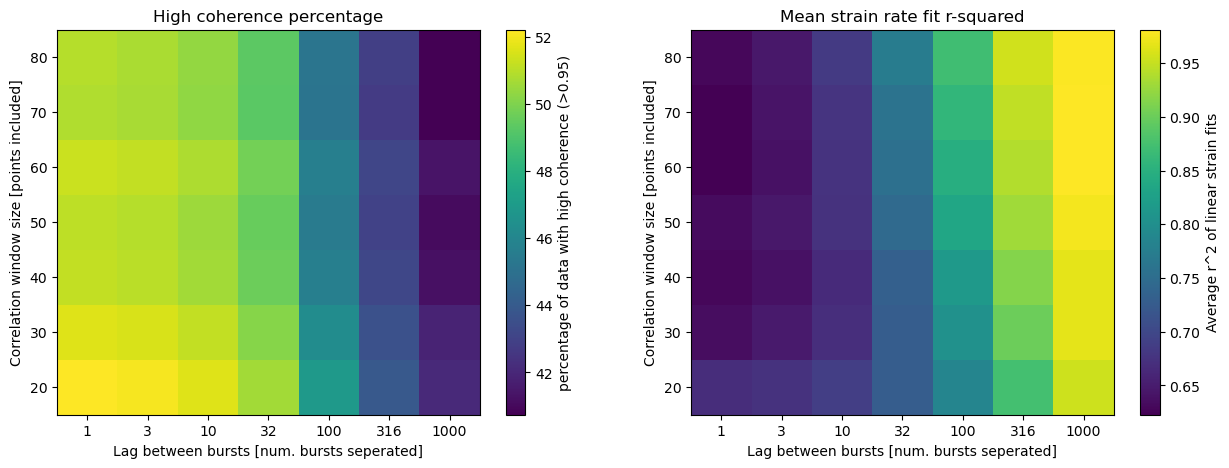

In [20]:
best_window,best_lag = optimal_window_and_leapfrog(to_plot)
print(f'Best window: {best_window}, best lag: {best_lag}')

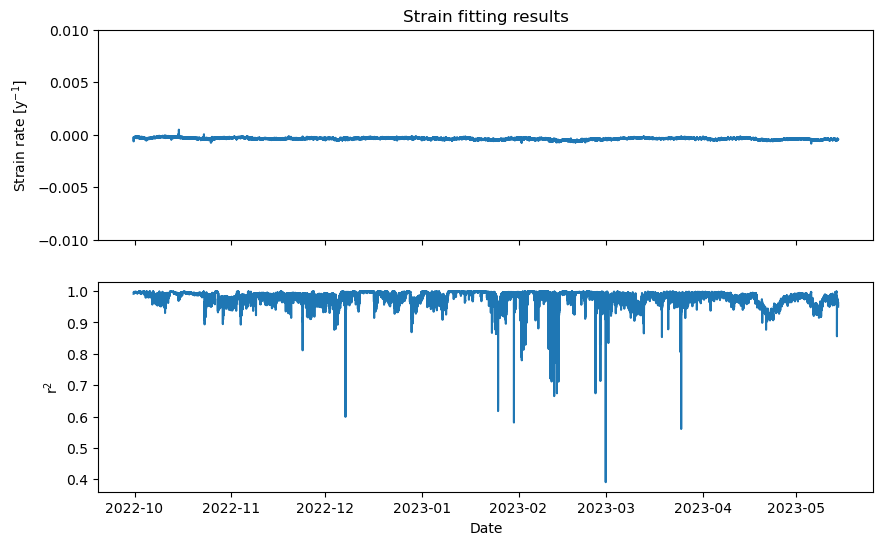

In [21]:
generate_strain_fit(to_plot,best_window,best_lag)

## Summer 2022
### Profiles

In [22]:
to_plot = ds_103.profile_stacked.isel(attenuator_setting_pair=0).compute()
to_plot

<xarray.DataArray 'profile_stacked' (time: 11703, profile_range: 6658)>
array([[ 1.02308835e-02+0.00000000e+00j,  1.00222580e-05+9.01207670e-03j,
        -6.07514336e-03+1.00926123e-05j, ...,
        -6.30472608e-06-6.74847047e-06j,  6.85321573e-06-4.75900967e-06j,
         3.73715976e-06+6.55767974e-06j],
       [ 1.02284554e-02+0.00000000e+00j,  1.18964991e-05+9.01057552e-03j,
        -6.07531431e-03+1.24982102e-05j, ...,
         9.50567269e-06+2.34581981e-06j, -1.54877140e-06+6.04052418e-06j,
        -2.94616642e-06+5.27345772e-07j],
       [ 1.02283446e-02+0.00000000e+00j,  1.35567483e-05+9.01119547e-03j,
        -6.07737027e-03+1.51571232e-05j, ...,
        -1.95594065e-06-1.05697531e-06j,  1.86396618e-06-4.73906169e-07j,
        -3.18912033e-07+1.58375671e-06j],
       ...,
       [ 1.03156488e-02+0.00000000e+00j,  6.08042156e-05+9.05201101e-03j,
        -5.99609663e-03+1.26063658e-04j, ...,
         3.87626309e-06-1.06942226e-05j,  1.60192678e-05+9.60167026e-06j,
        -1.51561212e-05+1.70162215e-05j],
       [ 1.03225132e-02+0.00000000e+00j,  3.50539358e-05+9.06505655e-03j,
        -6.02511056e-03+6.60817784e-05j, ...,
         2.19465535e-06-1.60114937e-05j,  1.56835829e-05+5.10644325e-06j,
        -7.09762922e-06+1.30922022e-05j],
       [ 1.03429722e-02+0.00000000e+00j,  1.69547374e-05+9.09613553e-03j,
        -6.08474581e-03+2.36724059e-05j, ...,
         5.22306027e-07-1.77647140e-06j,  6.33632188e-07+2.16390455e-06j,
        -2.58785719e-06+1.13971437e-07j]])
Coordinates:
    AFGain         int64 -4
    attenuator     float64 5.0
    burst_number   (time) int64 3 4 5 6 7 8 9 10 11 ... 25 26 27 28 29 30 31 32
    filename       (time) <U83 'ldeo-glaciology/GL_apres_2022/A103/CardA/DIR2...
  * profile_range  (profile_range) float64 0.0 0.2103 0.4206 ... 1.4e+03 1.4e+03
  * time           (time) datetime64[ns] 2022-05-26T14:13:15 ... 2022-09-25T1...

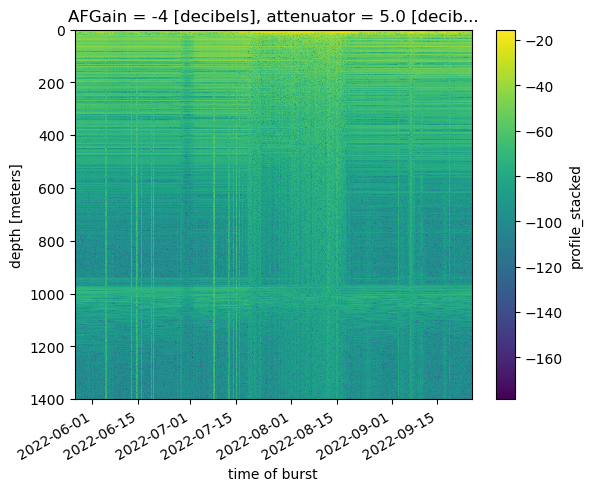

In [23]:
fig, ax = plt.subplots()

xa.dB(to_plot).plot(ax=ax,x='time')
ax.invert_yaxis()

In [24]:
da_103_stacked  = custom_stacked_profile_series(ds_103.chirp.isel(attenuator_setting_pair=0),2,3e8,4e8)


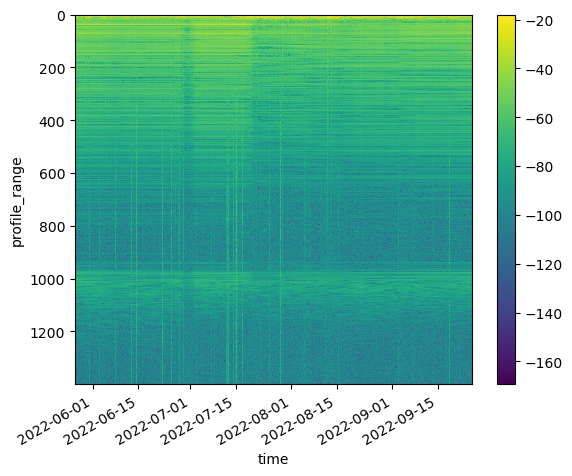

In [25]:
fig, ax = plt.subplots()

xa.dB(da_103_stacked).plot(ax=ax,x='time')
ax.invert_yaxis()

Still some discontinuities

### Strain Rate

Window 20, lag 1 -> pct 0.52, r2 0.66
Window 20, lag 3 -> pct 0.51, r2 0.65
Window 20, lag 10 -> pct 0.48, r2 0.69
Window 20, lag 32 -> pct 0.43, r2 0.76
Window 20, lag 100 -> pct 0.38, r2 0.81
Window 20, lag 316 -> pct 0.27, r2 0.9
Window 20, lag 1000 -> pct 0.15, r2 0.92
Window 30, lag 1 -> pct 0.51, r2 0.64
Window 30, lag 3 -> pct 0.5, r2 0.64
Window 30, lag 10 -> pct 0.47, r2 0.71
Window 30, lag 32 -> pct 0.42, r2 0.79
Window 30, lag 100 -> pct 0.37, r2 0.85
Window 30, lag 316 -> pct 0.26, r2 0.94
Window 30, lag 1000 -> pct 0.13, r2 0.93
Window 40, lag 1 -> pct 0.51, r2 0.64
Window 40, lag 3 -> pct 0.49, r2 0.66
Window 40, lag 10 -> pct 0.47, r2 0.73
Window 40, lag 32 -> pct 0.41, r2 0.82
Window 40, lag 100 -> pct 0.36, r2 0.87
Window 40, lag 316 -> pct 0.25, r2 0.95
Window 40, lag 1000 -> pct 0.12, r2 0.93
Window 50, lag 1 -> pct 0.51, r2 0.65
Window 50, lag 3 -> pct 0.5, r2 0.68
Window 50, lag 10 -> pct 0.47, r2 0.75
Window 50, lag 32 -> pct 0.41, r2 0.83
Window 50, lag 100 -> pc

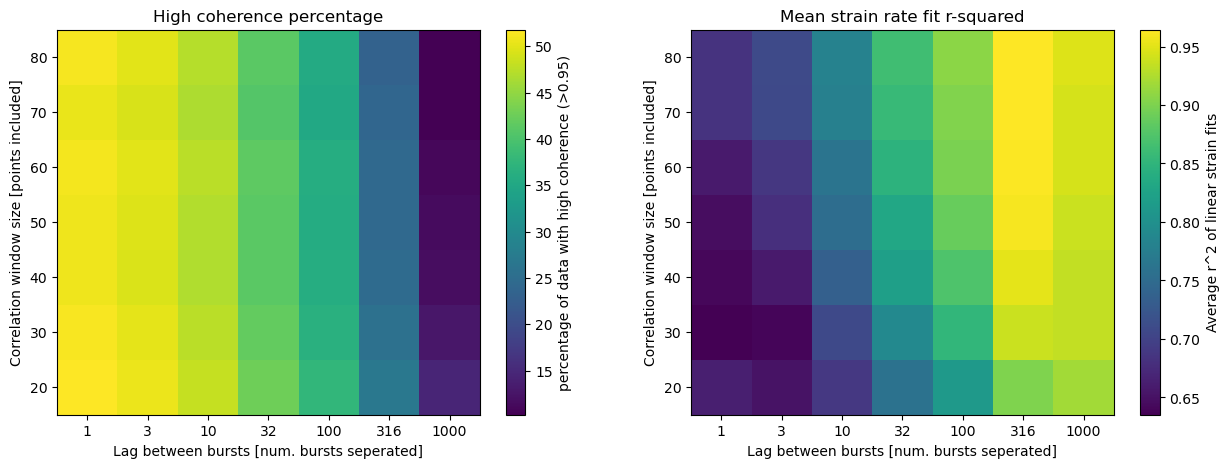

In [26]:
best_window,best_lag = optimal_window_and_leapfrog(da_103_stacked)
print(f'Best window: {best_window}, best lag: {best_lag}')

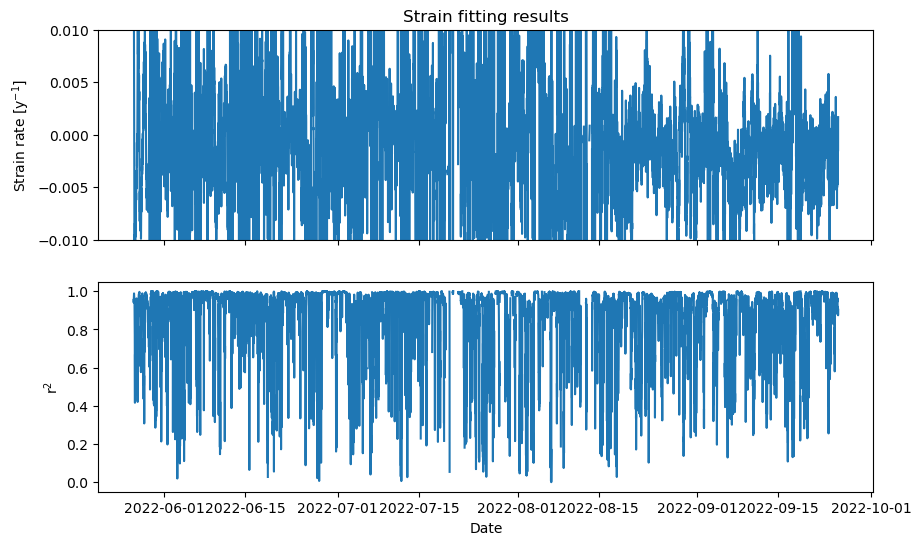

In [27]:
generate_strain_fit(da_103_stacked,best_window,best_lag)

In [28]:
del da_103_stacked

## Summer 2023
### Profiles

In [29]:
to_plot = ds_103_s.profile_stacked.isel(attenuator_setting_pair=2).compute()
to_plot

<xarray.DataArray 'profile_stacked' (time: 47375, profile_range: 6658)>
array([[ 9.19800954e-03+0.00000000e+00j,  5.52394037e-05+8.10151394e-03j,
        -5.45780266e-03+8.17386866e-05j, ...,
         9.88636013e-06-1.04125794e-05j,  7.10000536e-06+1.42066659e-05j,
        -1.73388604e-05+2.44340125e-06j],
       [ 9.19597612e-03+0.00000000e+00j,  5.95976287e-05+8.09215737e-03j,
        -5.43168435e-03+8.84741132e-05j, ...,
         6.86177128e-06-4.48617900e-06j,  2.81556616e-06+5.42631563e-06j,
        -3.07784205e-06+1.64977894e-06j],
       [ 9.23264721e-03+0.00000000e+00j,  2.75891083e-05+8.12843044e-03j,
        -5.47332826e-03+2.90162459e-05j, ...,
        -4.94086782e-06-7.10397831e-06j,  6.93263364e-06+4.25182933e-06j,
        -1.13287479e-05+3.25014158e-06j],
       ...,
       [ 7.54182075e-03+0.00000000e+00j,  3.03062846e-04+6.51616874e-03j,
        -4.12460427e-03+5.22526494e-04j, ...,
         1.09276380e-05+3.75081431e-06j, -6.01063369e-06+8.86154641e-06j,
        -4.70097383e-06-5.30704770e-06j],
       [ 8.71610576e-03+0.00000000e+00j, -1.43786918e-04+7.61086407e-03j,
        -4.97294054e-03-3.31105568e-04j, ...,
        -1.25316083e-05-5.83971106e-06j,  1.16154362e-05-7.27121723e-06j,
         1.24448610e-07+1.08294057e-05j],
       [ 8.07795154e-03+0.00000000e+00j, -3.36803370e-04+6.91572211e-03j,
        -4.13054797e-03-5.27644844e-04j, ...,
         7.48121242e-05+8.76399819e-05j, -4.62783759e-05+8.29985982e-05j,
        -9.03811330e-05-3.09358776e-06j]])
Coordinates:
    AFGain         int64 6
    attenuator     float64 15.0
    burst_number   (time) int64 0 0 1 2 3 0 1 0 1 ... 46 47 48 49 50 51 52 53 54
    filename       (time) <U87 'ldeo-glaciology/GL_apres_2022/A103/summer_23/...
  * profile_range  (profile_range) float64 0.0 0.2103 0.4206 ... 1.4e+03 1.4e+03
  * time           (time) datetime64[ns] 2023-05-19T14:15:59 ... 2023-08-31T1...

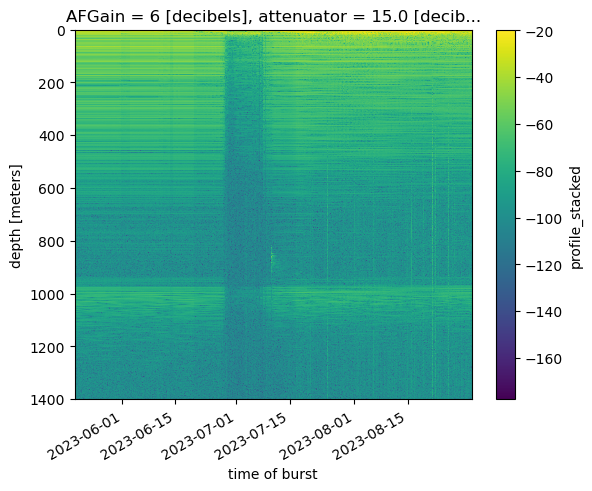

In [30]:
fig, ax = plt.subplots()

xa.dB(to_plot).plot(ax=ax,x='time')
ax.invert_yaxis()

Even with strongest attenuation settings, some bad data. Try applying half chirp.

In [45]:
da_103_stacked  = custom_stacked_profile_series(ds_103_s.chirp.isel(attenuator_setting_pair=2),2,3e8,4e8)


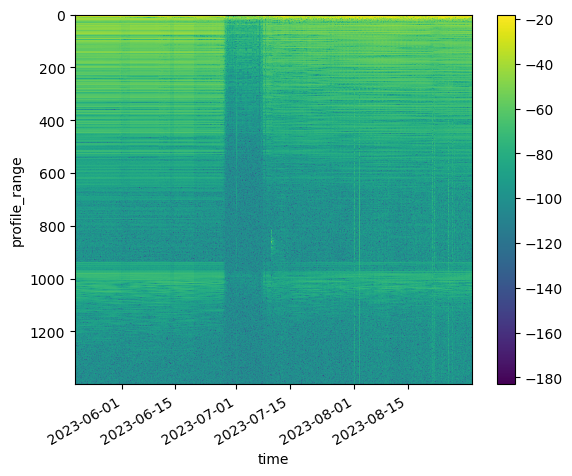

In [46]:
fig, ax = plt.subplots()

xa.dB(da_103_stacked).plot(ax=ax,x='time')
ax.invert_yaxis()

### Strain Rate

/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Window 20, lag 1 -> pct 0.51, r2 -inf


/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Window 20, lag 3 -> pct 0.51, r2 -inf
Window 20, lag 10 -> pct 0.5, r2 1.0
Window 20, lag 32 -> pct 0.48, r2 0.71
Window 20, lag 100 -> pct 0.44, r2 0.76
Window 20, lag 316 -> pct 0.4, r2 0.85
Window 20, lag 1000 -> pct 0.31, r2 0.92


/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Window 30, lag 1 -> pct 0.51, r2 -inf
Window 30, lag 3 -> pct 0.51, r2 1.0
Window 30, lag 10 -> pct 0.5, r2 1.0
Window 30, lag 32 -> pct 0.48, r2 0.71
Window 30, lag 100 -> pct 0.43, r2 0.77
Window 30, lag 316 -> pct 0.4, r2 0.87
Window 30, lag 1000 -> pct 0.3, r2 0.93


/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Window 40, lag 1 -> pct 0.51, r2 -inf


/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Window 40, lag 3 -> pct 0.5, r2 -inf
Window 40, lag 10 -> pct 0.49, r2 1.0
Window 40, lag 32 -> pct 0.47, r2 0.74
Window 40, lag 100 -> pct 0.42, r2 0.79
Window 40, lag 316 -> pct 0.39, r2 0.89
Window 40, lag 1000 -> pct 0.3, r2 0.93


/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Window 50, lag 1 -> pct 0.51, r2 -inf
Window 50, lag 3 -> pct 0.5, r2 1.0
Window 50, lag 10 -> pct 0.49, r2 1.0
Window 50, lag 32 -> pct 0.47, r2 0.74
Window 50, lag 100 -> pct 0.42, r2 0.8
Window 50, lag 316 -> pct 0.39, r2 0.9
Window 50, lag 1000 -> pct 0.29, r2 0.93


/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Window 60, lag 1 -> pct 0.51, r2 -inf


/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Window 60, lag 3 -> pct 0.51, r2 -inf
Window 60, lag 10 -> pct 0.5, r2 1.0
Window 60, lag 32 -> pct 0.47, r2 0.74
Window 60, lag 100 -> pct 0.43, r2 0.8
Window 60, lag 316 -> pct 0.39, r2 0.9
Window 60, lag 1000 -> pct 0.29, r2 0.94


/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Window 70, lag 1 -> pct 0.5, r2 -inf
Window 70, lag 3 -> pct 0.5, r2 1.0
Window 70, lag 10 -> pct 0.49, r2 1.0
Window 70, lag 32 -> pct 0.47, r2 0.77
Window 70, lag 100 -> pct 0.42, r2 0.83
Window 70, lag 316 -> pct 0.39, r2 0.91
Window 70, lag 1000 -> pct 0.29, r2 0.94


/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Window 80, lag 1 -> pct 0.51, r2 -inf
Window 80, lag 3 -> pct 0.5, r2 1.0
Window 80, lag 10 -> pct 0.5, r2 1.0
Window 80, lag 32 -> pct 0.47, r2 0.76
Window 80, lag 100 -> pct 0.42, r2 0.82
Window 80, lag 316 -> pct 0.39, r2 0.91
Window 80, lag 1000 -> pct 0.28, r2 0.93
Best window: 30, best lag: 3


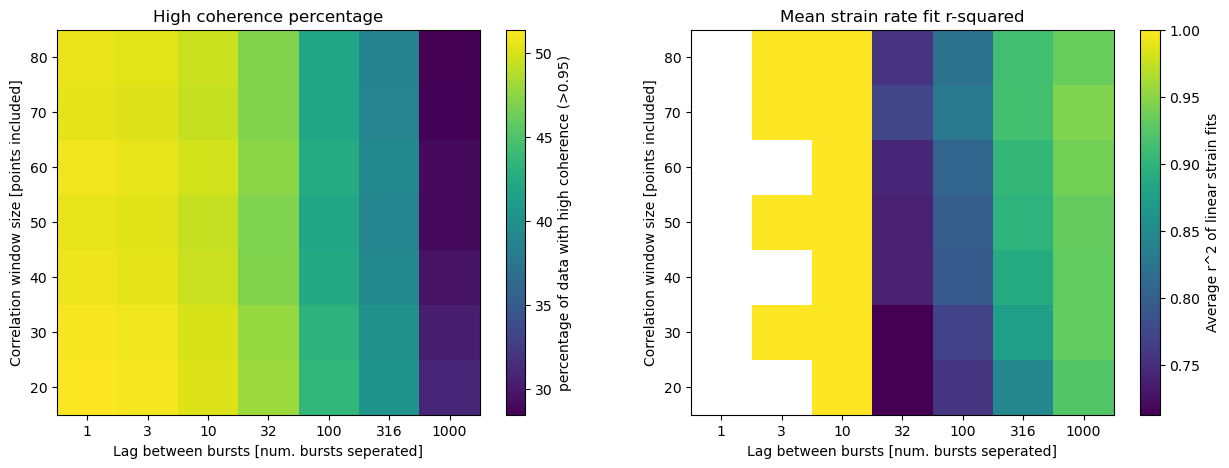

In [39]:
best_window,best_lag = optimal_window_and_leapfrog(da_103_stacked)
print(f'Best window: {best_window}, best lag: {best_lag}')

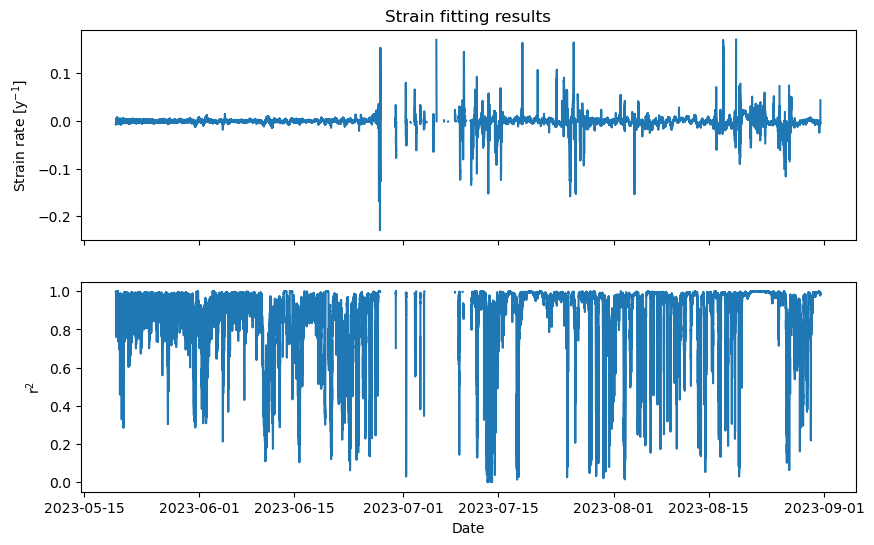

In [48]:
generate_strain_fit(da_103_stacked,70,200)

In [49]:
del da_103_stacked

# Station A14

## Winter 2023
### Profiles
We will use settings A= 5dB and G = -4 dB.

In [50]:
to_plot = ds_104_w.profile_stacked.isel(attenuator_setting_pair=0).compute()
to_plot

<xarray.DataArray 'profile_stacked' (time: 11201, profile_range: 6658)>
array([[ 8.80516206e-03+0.00000000e+00j,  1.14958270e-06+7.75084305e-03j,
        -5.21840911e-03+1.22791724e-06j, ...,
        -2.38226657e-07-4.41114976e-06j,  5.65078426e-06+1.47887150e-06j,
        -3.07353616e-06+5.15813545e-06j],
       [ 8.80085204e-03+0.00000000e+00j,  5.78474130e-07+7.74830037e-03j,
        -5.21932195e-03+6.05488026e-06j, ...,
         8.95547533e-06+9.24833916e-06j, -5.84101059e-06+3.42340600e-06j,
         2.85464413e-06+1.07120683e-06j],
       [ 8.79510439e-03+0.00000000e+00j,  2.32397834e-05+7.73934344e-03j,
        -5.20173885e-03+4.75407695e-05j, ...,
        -8.45240884e-06+8.90665308e-06j, -5.76373446e-06-7.19777338e-06j,
         3.64589257e-06-3.63626366e-06j],
       ...,
       [ 8.51345397e-03+0.00000000e+00j,  1.63450933e-05+7.49491564e-03j,
        -5.04592275e-03+3.44893686e-05j, ...,
         7.09639529e-06-6.82143287e-06j,  5.98943718e-06+5.24983288e-06j,
        -2.24761005e-06+5.32171017e-06j],
       [ 8.50942953e-03+0.00000000e+00j,  1.62989498e-05+7.49137915e-03j,
        -5.04355413e-03+3.43977366e-05j, ...,
         2.37997308e-06-3.28566661e-06j,  9.79965105e-07+1.85305971e-06j,
        -8.77553590e-07-5.24382112e-07j],
       [ 8.50958087e-03+0.00000000e+00j,  1.63166334e-05+7.49148300e-03j,
        -5.04355042e-03+3.44315112e-05j, ...,
         4.59180500e-06-3.68574946e-06j,  2.93178779e-06+3.15136667e-06j,
        -1.76477788e-06+1.91200500e-06j]])
Coordinates:
    AFGain         int64 -4
    attenuator     float64 10.0
    burst_number   (time) int64 0 0 1 2 3 4 5 6 7 ... 57 58 59 60 61 62 63 64 65
    filename       (time) <U89 'ldeo-glaciology/GL_apres_2022/A104/winter22_2...
  * profile_range  (profile_range) float64 0.0 0.2103 0.4206 ... 1.4e+03 1.4e+03
  * time           (time) datetime64[ns] 2022-09-25T13:49:28 ... 2023-03-24T0...

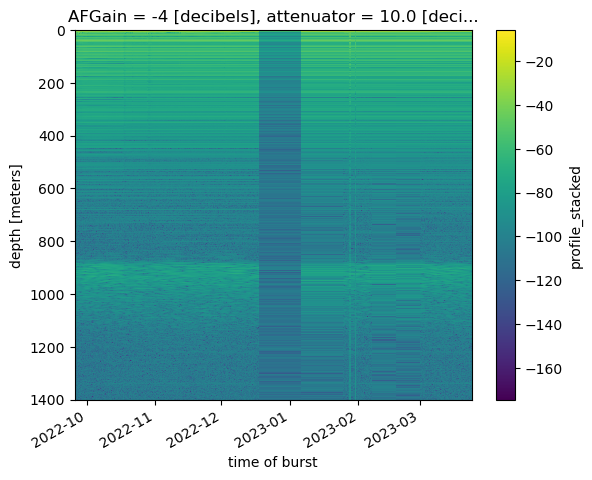

In [51]:
fig, ax = plt.subplots()

xa.dB(to_plot).plot(ax=ax,x='time')
ax.invert_yaxis()

### Strain Rates

Window 20, lag 1 -> pct 0.56, r2 0.65
Window 20, lag 3 -> pct 0.56, r2 0.66
Window 20, lag 10 -> pct 0.56, r2 0.71
Window 20, lag 32 -> pct 0.53, r2 0.87
Window 20, lag 100 -> pct 0.44, r2 0.94
Window 20, lag 316 -> pct 0.41, r2 0.49
Window 20, lag 1000 -> pct 0.4, r2 0.56
Window 30, lag 1 -> pct 0.55, r2 0.6
Window 30, lag 3 -> pct 0.55, r2 0.61
Window 30, lag 10 -> pct 0.55, r2 0.7
Window 30, lag 32 -> pct 0.52, r2 0.9
Window 30, lag 100 -> pct 0.43, r2 0.93
Window 30, lag 316 -> pct 0.41, r2 0.43
Window 30, lag 1000 -> pct 0.39, r2 0.57
Window 40, lag 1 -> pct 0.55, r2 0.58
Window 40, lag 3 -> pct 0.55, r2 0.59
Window 40, lag 10 -> pct 0.54, r2 0.72
Window 40, lag 32 -> pct 0.52, r2 0.92
Window 40, lag 100 -> pct 0.42, r2 0.93
Window 40, lag 316 -> pct 0.4, r2 0.43
Window 40, lag 1000 -> pct 0.39, r2 0.59
Window 50, lag 1 -> pct 0.55, r2 0.56
Window 50, lag 3 -> pct 0.54, r2 0.58
Window 50, lag 10 -> pct 0.54, r2 0.73
Window 50, lag 32 -> pct 0.51, r2 0.93
Window 50, lag 100 -> pct 

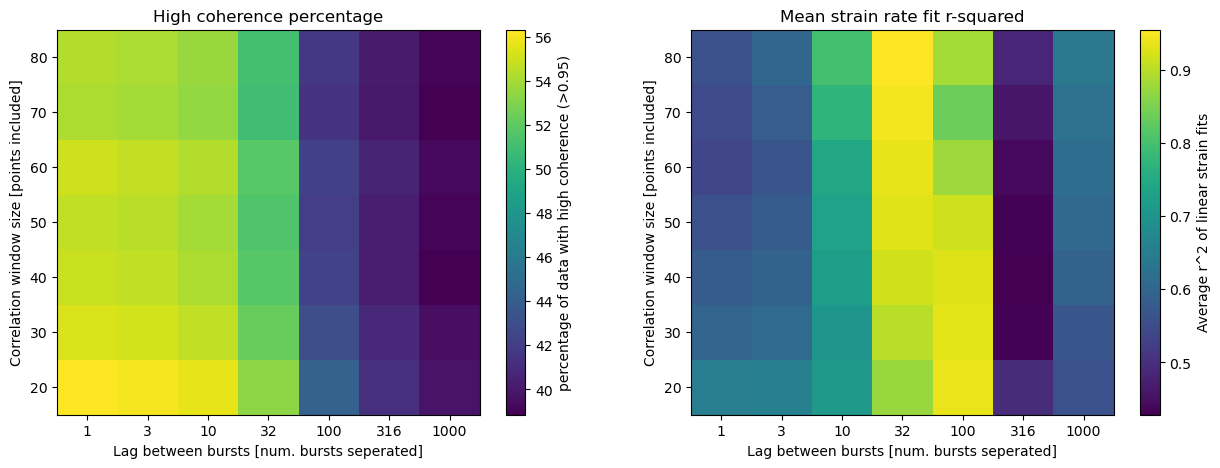

In [52]:
best_window,best_lag = optimal_window_and_leapfrog(to_plot)
print(f'Best window: {best_window}, best lag: {best_lag}')

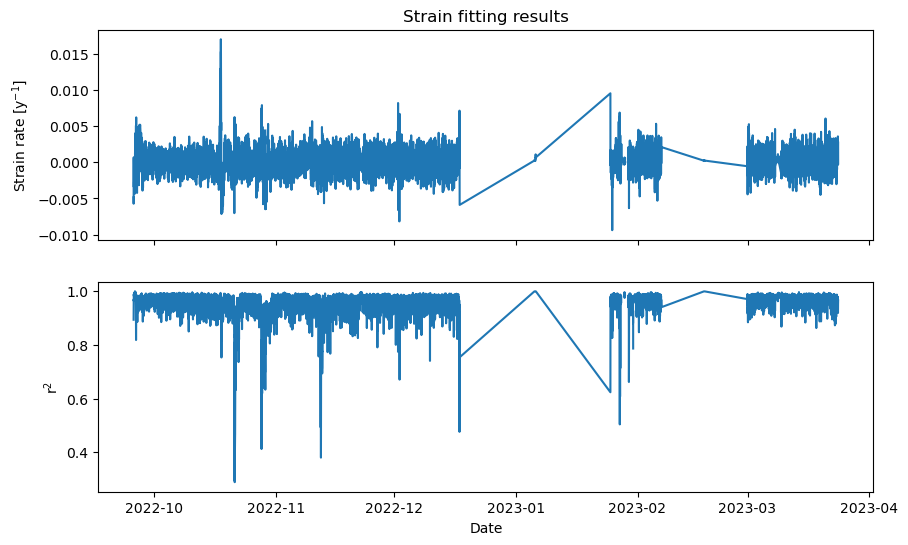

In [53]:
generate_strain_fit(to_plot,best_window,best_lag)

In [54]:
del to_plot

## Summer 2022
### Profiles

In [55]:
to_plot = ds_104.profile_stacked.isel(attenuator_setting_pair=0).compute()
to_plot

<xarray.DataArray 'profile_stacked' (time: 11691, profile_range: 6658)>
array([[ 8.81878605e-03+0.00000000e+00j,  1.62365534e-05+7.76312337e-03j,
        -5.22810185e-03+3.26968996e-05j, ...,
        -3.45174032e-06-2.93691793e-07j, -5.80575504e-07-2.81518347e-06j,
         2.55956166e-06-8.39930162e-07j],
       [ 8.81119275e-03+0.00000000e+00j,  2.37921821e-05+7.76266423e-03j,
        -5.24084157e-03+3.77737222e-05j, ...,
        -2.29927173e-06-4.60340778e-06j,  5.81694072e-06-8.86534169e-07j,
        -3.68193049e-07+5.12190181e-06j],
       [ 8.80590805e-03+0.00000000e+00j,  2.40407112e-05+7.75739510e-03j,
        -5.23592789e-03+3.83429495e-05j, ...,
         1.58905469e-06-1.93774065e-06j,  2.90899184e-06+1.56215465e-06j,
        -1.96439424e-06+3.27690807e-06j],
       ...,
       [ 8.84754907e-03+0.00000000e+00j,  1.79986287e-05+7.78881278e-03j,
        -5.24766387e-03+3.79867779e-05j, ...,
         1.86732104e-06-3.12621192e-06j,  3.41587500e-06+1.20198428e-06j,
        -5.81846573e-07+3.72058561e-06j],
       [ 8.84218553e-03+0.00000000e+00j,  1.81174958e-05+7.78410587e-03j,
        -5.24460969e-03+3.83339077e-05j, ...,
         5.00562523e-06-3.43150849e-06j,  3.34773226e-06+4.78503949e-06j,
        -4.42320356e-06+3.71893028e-06j],
       [ 8.84541217e-03+0.00000000e+00j,  1.80494942e-05+7.78694987e-03j,
        -5.24650157e-03+3.82083253e-05j, ...,
         1.86884159e-06-2.09339717e-06j,  4.41743931e-07+1.37195154e-06j,
        -6.10335028e-07-1.11939795e-06j]])
Coordinates:
    AFGain         int64 -4
    attenuator     float64 10.0
    burst_number   (time) int64 3 4 5 6 7 8 9 10 11 12 ... 5 6 7 8 9 10 11 12 13
    filename       (time) <U83 'ldeo-glaciology/GL_apres_2022/A104/CardA/DIR2...
  * profile_range  (profile_range) float64 0.0 0.2103 0.4206 ... 1.4e+03 1.4e+03
  * time           (time) datetime64[ns] 2022-05-26T18:33:17 ... 2022-09-25T1...

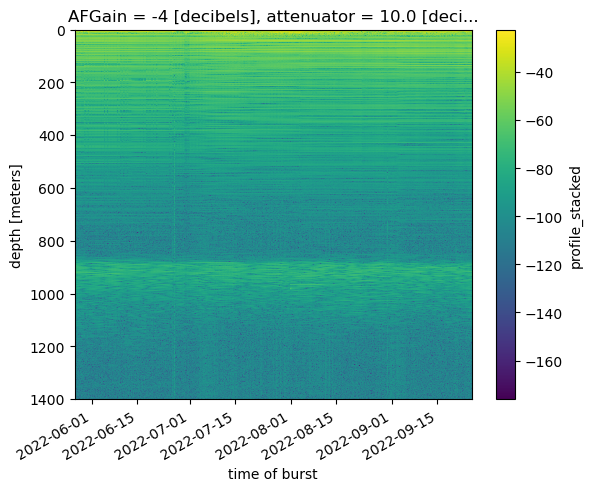

In [56]:
fig, ax = plt.subplots()

xa.dB(to_plot).plot(ax=ax,x='time')
ax.invert_yaxis()

### Strain Rate

Window 20, lag 1 -> pct 0.57, r2 0.64
Window 20, lag 3 -> pct 0.57, r2 0.64
Window 20, lag 10 -> pct 0.54, r2 0.73
Window 20, lag 32 -> pct 0.48, r2 0.86
Window 20, lag 100 -> pct 0.4, r2 0.9
Window 20, lag 316 -> pct 0.3, r2 0.87
Window 20, lag 1000 -> pct 0.16, r2 0.89
Window 30, lag 1 -> pct 0.56, r2 0.59
Window 30, lag 3 -> pct 0.56, r2 0.62
Window 30, lag 10 -> pct 0.53, r2 0.75
Window 30, lag 32 -> pct 0.47, r2 0.89
Window 30, lag 100 -> pct 0.38, r2 0.89
Window 30, lag 316 -> pct 0.29, r2 0.87
Window 30, lag 1000 -> pct 0.14, r2 0.88
Window 40, lag 1 -> pct 0.56, r2 0.57
Window 40, lag 3 -> pct 0.55, r2 0.61
Window 40, lag 10 -> pct 0.53, r2 0.77
Window 40, lag 32 -> pct 0.46, r2 0.91
Window 40, lag 100 -> pct 0.38, r2 0.89
Window 40, lag 316 -> pct 0.28, r2 0.93
Window 40, lag 1000 -> pct 0.13, r2 0.95
Window 50, lag 1 -> pct 0.55, r2 0.55
Window 50, lag 3 -> pct 0.55, r2 0.61
Window 50, lag 10 -> pct 0.52, r2 0.79
Window 50, lag 32 -> pct 0.46, r2 0.93
Window 50, lag 100 -> pc

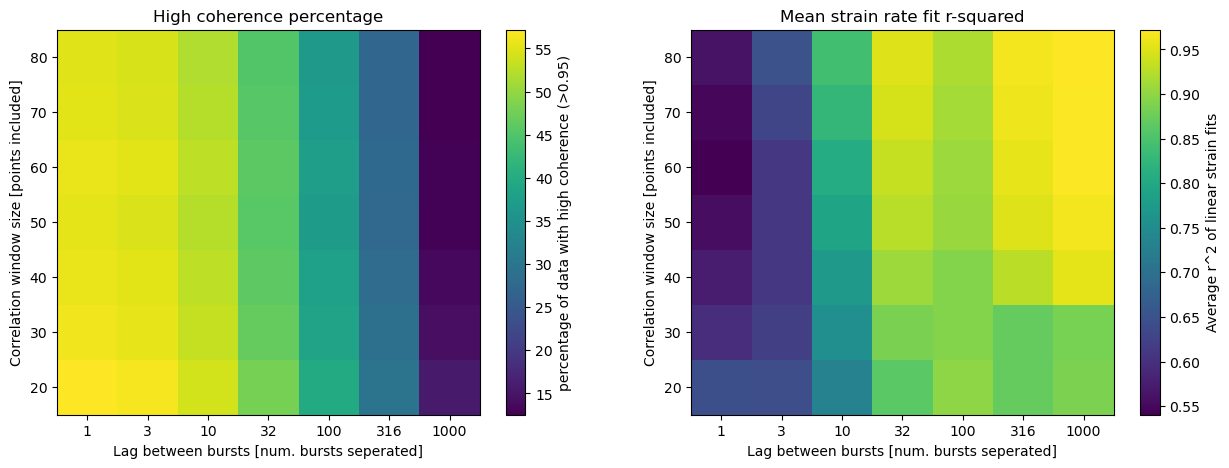

In [57]:
best_window,best_lag = optimal_window_and_leapfrog(to_plot)
print(f'Best window: {best_window}, best lag: {best_lag}')

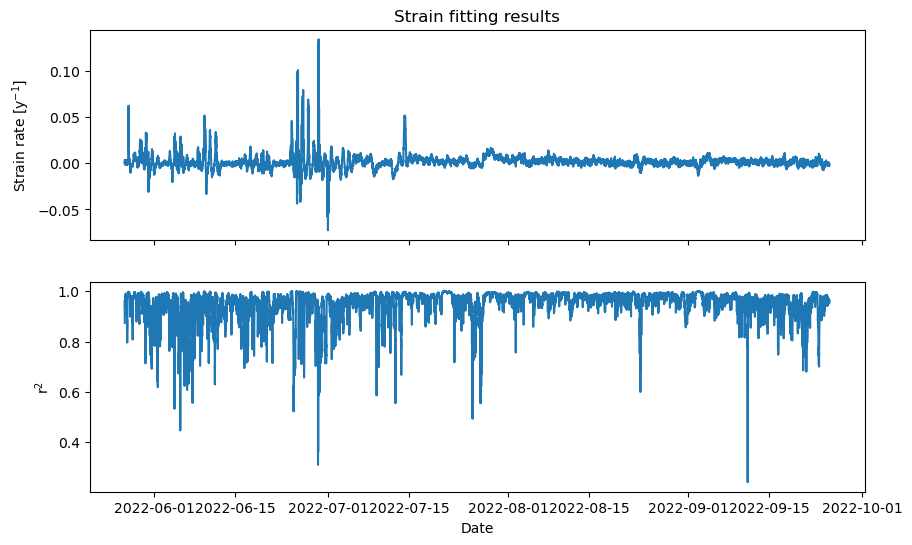

In [58]:
generate_strain_fit(to_plot,best_window,best_lag)

In [59]:
del to_plot

## Summer 2023
### Profiles

In [60]:
to_plot = ds_104_s.profile_stacked.isel(attenuator_setting_pair=2).compute()
to_plot

<xarray.DataArray 'profile_stacked' (time: 9705, profile_range: 6658)>
array([[ 6.90209091e-03+0.00000000e+00j,  2.42593613e-05+6.09164209e-03j,
        -4.13034005e-03+1.27284119e-05j, ...,
        -2.50450295e-05-5.22284476e-05j,  4.93118025e-05-2.56404066e-05j,
         2.73944634e-05+4.70562691e-05j],
       [ 7.13987350e-03+0.00000000e+00j,  6.66329496e-06+6.32041815e-03j,
        -4.35863012e-03-1.97847168e-05j, ...,
         1.50141838e-05-4.15628314e-05j,  2.63321178e-05+8.37278124e-06j,
         5.68318231e-06+5.37058406e-06j],
       [ 6.91576323e-03+0.00000000e+00j,  3.38477554e-05+6.09168623e-03j,
        -4.10280165e-03+4.87027573e-05j, ...,
         6.63143543e-06-4.70367091e-07j,  7.62201895e-09+2.97189305e-06j,
        -1.24378796e-06-1.35609048e-06j],
       ...,
       [ 6.80257361e-03+0.00000000e+00j,  8.09933514e-05+6.01874967e-03j,
        -4.10613471e-03+1.04786094e-04j, ...,
         3.84400303e-06-1.94657886e-05j,  1.91718203e-05+3.25572654e-06j,
        -3.71898298e-06+1.92350305e-05j],
       [ 6.80752264e-03+0.00000000e+00j,  7.61839086e-05+6.01937738e-03j,
        -4.09999152e-03+1.03248272e-04j, ...,
         8.43020158e-06-2.63512885e-05j,  2.67696158e-05+5.06315768e-06j,
        -5.54165922e-06+2.37833386e-05j],
       [ 6.82277805e-03+0.00000000e+00j,  6.82720686e-05+6.02777924e-03j,
        -4.09678637e-03+9.83136194e-05j, ...,
         6.72706430e-06-1.48169190e-05j,  1.41352098e-05+3.27820401e-06j,
        -4.67550219e-06+1.19152740e-05j]])
Coordinates:
    AFGain         int64 6
    attenuator     float64 15.0
    burst_number   (time) int64 0 0 1 2 3 4 5 6 7 ... 45 46 47 48 49 50 51 52 53
    filename       (time) <U87 'ldeo-glaciology/GL_apres_2022/A104/summer_23/...
  * profile_range  (profile_range) float64 0.0 0.2103 0.4206 ... 1.4e+03 1.4e+03
  * time           (time) datetime64[ns] 2023-05-22T17:04:27 ... 2023-08-31T1...

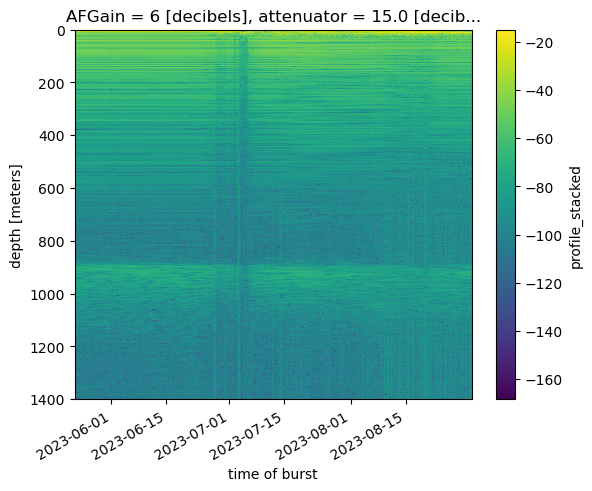

In [61]:
fig, ax = plt.subplots()

xa.dB(to_plot).plot(ax=ax,x='time')
ax.invert_yaxis()

In [62]:
da_104_stacked  = custom_stacked_profile_series(ds_104_s.chirp.isel(attenuator_setting_pair=0),2,3e8,4e8)


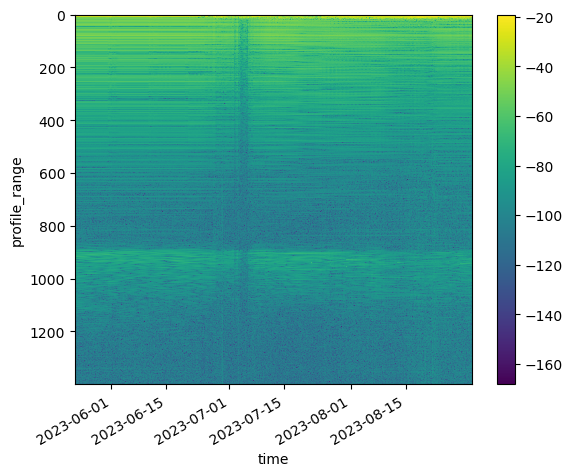

In [63]:
fig, ax = plt.subplots()

xa.dB(da_104_stacked).plot(ax=ax,x='time')
ax.invert_yaxis()

### Strain Rate

Window 20, lag 1 -> pct 0.53, r2 0.63
Window 20, lag 3 -> pct 0.52, r2 0.64
Window 20, lag 10 -> pct 0.49, r2 0.73
Window 20, lag 32 -> pct 0.41, r2 0.86
Window 20, lag 100 -> pct 0.34, r2 0.88
Window 20, lag 316 -> pct 0.21, r2 0.92
Window 20, lag 1000 -> pct 0.11, r2 0.7
Window 30, lag 1 -> pct 0.52, r2 0.57
Window 30, lag 3 -> pct 0.51, r2 0.6
Window 30, lag 10 -> pct 0.48, r2 0.76
Window 30, lag 32 -> pct 0.4, r2 0.9
Window 30, lag 100 -> pct 0.33, r2 0.89
Window 30, lag 316 -> pct 0.2, r2 0.96
Window 30, lag 1000 -> pct 0.1, r2 0.67
Window 40, lag 1 -> pct 0.51, r2 0.59
Window 40, lag 3 -> pct 0.5, r2 0.64
Window 40, lag 10 -> pct 0.47, r2 0.8
Window 40, lag 32 -> pct 0.4, r2 0.91
Window 40, lag 100 -> pct 0.32, r2 0.89
Window 40, lag 316 -> pct 0.19, r2 0.97
Window 40, lag 1000 -> pct 0.1, r2 0.63
Window 50, lag 1 -> pct 0.51, r2 0.58
Window 50, lag 3 -> pct 0.5, r2 0.64
Window 50, lag 10 -> pct 0.47, r2 0.81
Window 50, lag 32 -> pct 0.39, r2 0.92
Window 50, lag 100 -> pct 0.32, 

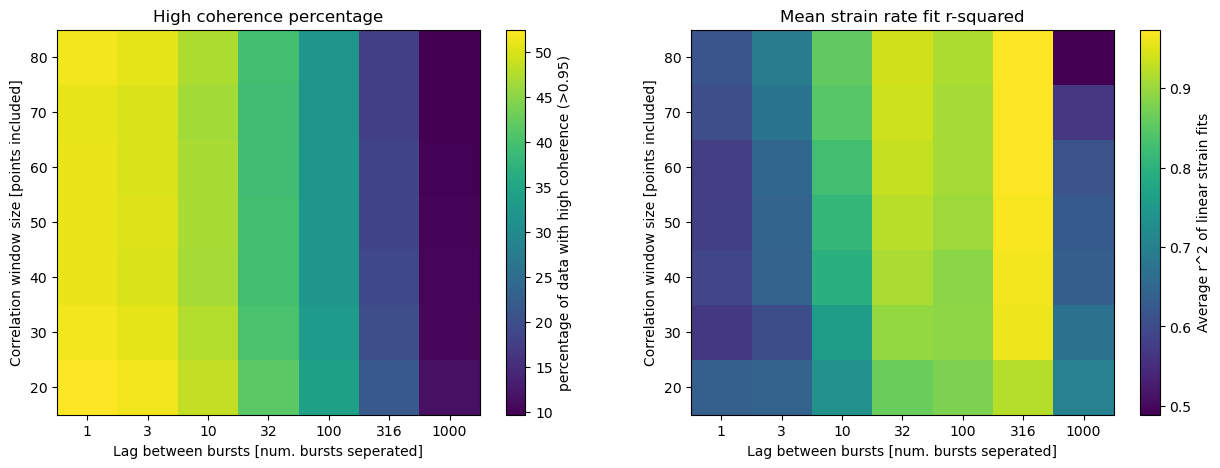

In [64]:
best_window,best_lag = optimal_window_and_leapfrog(da_104_stacked)
print(f'Best window: {best_window}, best lag: {best_lag}')

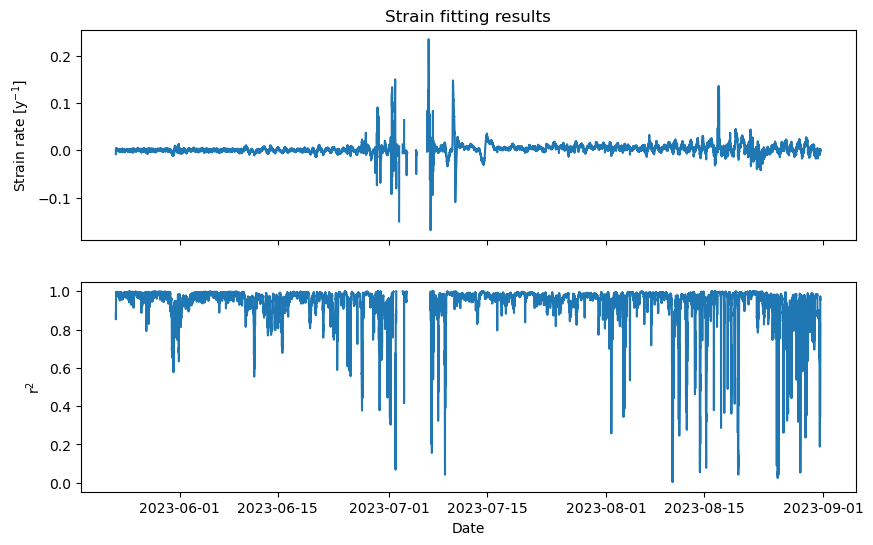

In [66]:
generate_strain_fit(da_104_stacked,best_window,best_lag)